### **Imports**<br>
Import najważniejszych pakietów takich jak:
*   **imutils** - narzędzia do edycji plików graficznych
*   **dlib** - biblioteka zawierająca modele biometryczne HOG oraz CNN, które wykorzystamy do wykrywania twarzy
*   **cv2** - narzędzia do przetwarzania plików graficznych
*   **matplotlib.pyplot** - narzędzia do szczegółowego prezentowania przetwarzanych plików graficznych
*   **numpy** - narzędzia do obsługi macierzy (obraz jako macierz w naszym pryzpadku)
*   **CNN_model** - plik z konfiguracją modelu CNN
*   **hog_face_detector** - inicjalizacja modelu HOG z biblioteki dlib







In [1]:
# import the necessary packages
import imutils
import dlib
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

CNN_model = "./mmod_human_face_detector.dat"
upsample = 1  #change to 2 if you want more accuracy
hog_face_detector = dlib.get_frontal_face_detector()

### **Functions**<br>
Funkcje składowe algorytmu anonimizacji:
*   **HOG_num_of_faces** - funkcja odpowiedzialna za wykrycie i ustalenie ilości twarzy na zdjęciu za pomocą modelu HOG
*   **CNN_num_of_faces** - funkcja odpowiedzialna za wykrycie i ustalenie ilości twarzy na zdjęciu za pomocą modelu CNN
*   **convert_and_trim_bb** - funkcja odpowiedzialna za wykrycie twarzy, wycięcie jej oraz odpowiednią konwersję
*   **HOG_face_detection** - funkcja odpowiedzialna za wykonanie odpowiednich działań prowadzących do anonimizacji zdjęcia z wykorzystaniem modelu HOG
*   **CNN_face_detection** - funkcja odpowiedzialna za wykonanie odpowiednich działań prowadzących do anonimizacji zdjęcia z wykorzystaniem modelu CNN
*   **AAA** - funkcja głowna obsługująca powyższe zgodnie z zadanymi przez nas parametrami oraz na zadanym źródłowym pliku graficznym



### HOG_num_of_faces
Schemat działania:
1.   Wczytanie pliku graficznego z podanej ścieżki
2.   Konwersja obrazu z palety barw BGR do RGB
1.   Przetworzenie przygotowanego obrazu przez model HOG
2.   Zwrócenie liczby znalezionych elementów (czyli twarzy)


In [2]:
def HOG_num_of_faces(image, hog_face_detector):
  image = cv2.imread(image)
  
  # Convert the image from BGR into RGB format.
  imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Perform the face detection on the image.
  results = hog_face_detector(imgRGB, 0)
  num_of_faces = len(results)

  return num_of_faces

### CNN_num_of_faces
Schemat działania:
1.   Inicjalizacja modelu CNN z biblioteki dlib za pomocą pliku konfiguracyjnego CNN_model
1.   Wczytanie pliku graficznego z podanej ścieżki
2.   Konwersja obrazu z palety barw BGR do RGB oraz przeskalowanie w celu optymalizacji pracy modelu CNN
1.   Przetworzenie przygotowanego obrazu przez model CNN
2.   Zwrócenie liczby znalezionych elementów (czyli twarzy)


In [5]:
def CNN_num_of_faces(image, model):

  cnn_face_detector = dlib.cnn_face_detection_model_v1(model)

  # load the input image from disk, resize it, and convert it from
  # BGR to RGB channel ordering (which is what dlib expects)
  image = cv2.imread(image)
  image = imutils.resize(image, width=600)
  rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # perform face detection using dlib's face detector
  results = cnn_face_detector(rgb, upsample)
  num_of_faces = len(results)

  return num_of_faces

### convert_and_trim_bb
Schemat działania:
1.   Ekstrakcja koordynatów brzegowych ramki ze znalezioną w niej twarzą
2.   Sprawdzenie, czy znaleziona ramka zawiera się w obszarze oryginalnego obrazu
1.   Wyznaczenie długości i szerokości ramki
2.   Zwrócenie koordynatów, w których zaczyna się ramka oraz jej długości i szerokości, co pozwala określić jej położenie na zdjęciu


In [6]:
def convert_and_trim_bb(image, rect):
	# extract the starting and ending (x, y)-coordinates of the
	# bounding box
	startX = rect.left()
	startY = rect.top()
	endX = rect.right()
	endY = rect.bottom()
	# ensure the bounding box coordinates fall within the spatial
	# dimensions of the image
	startX = max(0, startX)
	startY = max(0, startY)
	endX = min(endX, image.shape[1])
	endY = min(endY, image.shape[0])
	# compute the width and height of the bounding box
	w = endX - startX
	h = endY - startY
	# return our bounding box coordinates
	return (startX, startY, w, h)

### HOG_face_detection
Schemat działania:
1.   Wczytanie pliku graficznego z podanej ścieżki
1.   Ekstrakcja wysokości i długości obrazu
2.   Konwersja oryginału obrazu z palety barw BGR do RGB
1.   Przetworzenie przygotowanego obrazu przez model HOG
1.   Stworzenie kopii oryginanego obrazu (tempImg) i przygotowanie maski o rozmiarach obrazu
2.   Pętla dla każdej znalezionej ramki z twarzą w środku:
  *   Wyznaczenie koordynatów startowych ramki
  *   Wyznaczenie długości i szerokości ramki
  *   Zablurowanie obszaru ramki na polu prostokąta dla kopii obrazu
  *   Stworzenie bluru w kształcie elipsy dla maski korzystając z koordynatów
  *   Nałożenie kształtu maski na zablurowany obszar dla kopii obrazu - to co poza elipsą zostaje odcięte
  *   Nałożenie maski na oryginalny obraz - wszystko w środku elipsy zablurowane, a poza widocznie jak w oryginale
1.   Wyświetlenie obrazu z zablurowanymi twarzami 


In [7]:
def HOG_face_detection(image, hog_face_detector):
    '''
    This function performs face(s) detection on an image using dlib hog face detector.
    Args:
        image:             The input image of the person(s) whose face needs to be detected.
        hog_face_detector: The hog face detection model required to perform the detection on the input image.
        display:           A boolean value that is if set to true the function displays the original input image, 
                           and the output image with the bounding boxes drawn and time taken written and returns nothing.
    Returns:
        output_image: A copy of input image with the bounding boxes drawn.
        results:      The output of the face detection process on the input image.
    '''
    
    # Read image from path
    image = cv2.imread(image)

    # Get the height and width of the input image.
    height, width, _ = image.shape
    
    # Create a copy of the input image to draw bounding boxes on.
    # output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
    # Perform the face detection on the image.
    results = hog_face_detector(imgRGB, 0)

    # create a temp image and a mask to work on
    tempImg = image.copy()
    maskShape = (image.shape[0], image.shape[1], 1)
    mask = np.full(maskShape, 0, dtype=np.uint8)
 
    # Loop through the bounding boxes of each face detected in the image.
    for bbox in results:
        
        # Retrieve the left most x-coordinate of the bounding box.
        x1 = bbox.left()
        
        # Retrieve the top most y-coordinate of the bounding box.
        y1 = bbox.top()
        
        # Retrieve the right most x-coordinate of the bounding box.
        x2 = bbox.right()
        
        # Retrieve the bottom most y-coordinate of the bounding box.       
        y2 = bbox.bottom()

        # Normalize coordinates
        x = x1
        y = y1
        w = x2 - x1
        h = y2 - y1
        
        # Blur area inside box
        # output_image[y1:y2, x1:x2] = cv2.blur(image[y1:y2, x1:x2], (85,85), cv2.BORDER_DEFAULT)

        #Second way (circle / ellipse)
        #blur first so that the circle is not blurred
        tempImg [y:y+h, x:x+w] = cv2.blur(tempImg [y:y+h, x:x+w] ,(85,85))

        # ellipse
        cv2.ellipse(mask , (( int((x + x + w )/2), int((y + y + h)/2)),(w,h), 0), (255), -1)
    
    # apply the mask
    mask_inv = cv2.bitwise_not(mask)
    img1_bg = cv2.bitwise_and(image,image,mask = mask_inv)
    img2_fg = cv2.bitwise_and(tempImg,tempImg,mask = mask)
    dst = cv2.add(img1_bg,img2_fg)

    # show the output image
    cv2_imshow(dst)
    print("\n")

### CNN_face_detection
Schemat działania:
1.   Inicjalizacja modelu CNN z biblioteki dlib za pomocą pliku konfiguracyjnego CNN_model
1.   Wczytanie pliku graficznego z podanej ścieżki
2.   Konwersja oryginału obrazu z palety barw BGR do RGB oraz przeskalowanie w celu optymalizacji pracy modelu CNN
1.   Przetworzenie przygotowanego obrazu przez model CNN
1.   Zdobycie informacji co do położenia wszystkich wykrytych ramek za pomocą funkcji convert_and_trim_bb
1.   Stworzenie kopii oryginanego obrazu (tempImg) i przygotowanie maski o rozmiarach obrazu
2.   Pętla dla każdej znalezionej ramki z twarzą w środku:
  *   Pobranie informacji o położeniu ramek, długości i szerokości
  *   Zablurowanie obszaru ramki na polu prostokąta dla kopii obrazu
  *   Stworzenie bluru w kształcie elipsy dla maski korzystając z koordynatów
  *   Nałożenie kształtu maski na zablurowany obszar dla kopii obrazu - to co poza elipsą zostaje odcięte
  *   Nałożenie maski na oryginalny obraz - wszystko w środku elipsy zablurowane, a poza widocznie jak w oryginale
1.   Wyświetlenie obrazu z zablurowanymi twarzami 


In [8]:
def CNN_face_detection(image, model):

  # load dlib's CNN face detector
  # print("[INFO] loading CNN face detector...")
  detector = dlib.cnn_face_detection_model_v1(model)

  # load the input image from disk, resize it, and convert it from
  # BGR to RGB channel ordering (which is what dlib expects)
  image = cv2.imread(image)
  image = imutils.resize(image, width=600)
  rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # perform face detection using dlib's face detector
  # print("[INFO[ performing face detection with dlib...")
  results = detector(rgb, upsample)

  # convert the resulting dlib rectangle objects to bounding boxes,
  # then ensure the bounding boxes are all within the bounds of the
  # input image
  boxes = [convert_and_trim_bb(image, r.rect) for r in results]

  # create a temp image and a mask to work on
  tempImg = image.copy()
  maskShape = (image.shape[0], image.shape[1], 1)
  mask = np.full(maskShape, 0, dtype=np.uint8)
  
  # loop over the bounding boxes
  for (x, y, w, h) in boxes:
    # Blur area inside box (square)
    # image[y:y + h, x:x + w] = cv2.blur(image[y:y + h, x:x + w], (15,15), cv2.BORDER_DEFAULT)

    #Second way (circle / ellipse)
    #blur first so that the circle is not blurred
    tempImg [y:y+h, x:x+w] = cv2.blur(tempImg [y:y+h, x:x+w] ,(23,23))
    
    # create the circle in the mask and in the tempImg, notice the one in the mask is full
    # cv2.circle(tempImg , (int((x + x + w )/2), int((y + y + h)/2)), int (h / 2), (0, 255, 200), 5)
    # cv2.circle(mask , (int((x + x + w )/2), int((y + y + h)/2 )), int (h / 2), (255), -1)
    
    # ellipse
    cv2.ellipse(mask , (( int((x + x + w )/2), int((y + y + h)/2)),(w,h), 0), (255), -1)

  # apply the mask
  mask_inv = cv2.bitwise_not(mask)
  img1_bg = cv2.bitwise_and(image,image,mask = mask_inv)
  img2_fg = cv2.bitwise_and(tempImg,tempImg,mask = mask)
  dst = cv2.add(img1_bg,img2_fg)

  # show the output image
  cv2_imshow(dst)
  print("\n")

### AAA
Schemat działania:
1.   Sprawdzenie w jakim trybie ma zadziałać algorytm
1.   Dla trybu Advanced:
  *   Sprawdzenie, który model dokonał ilościowo więcej predykcji co do wykrywania twarzy na danym obrazie
  *   Dla tego modelu przeprowadza całą procedurę anonimiacji na danym obrazie
2.   Dla trybu Simple:
  *   Niezależnie od ilości wyznaczonych predykcji na danym obrazie, domyślnie używany jest model CNN
1.  Wykonanie działań zgodnie z wybranym trybem pracy
2.  Zebranie wyników odnośnie ilości wykrytych twarzy na danym obrazie


In [9]:
def AAA(img_list, prec_list, advance_mode=True):
  if (advance_mode):
    for i in img_list:
      CNN_faces = CNN_num_of_faces(i, CNN_model)
      HOG_faces = HOG_num_of_faces(i, hog_face_detector)

      if (CNN_faces >= HOG_faces):
        prec_list.append(CNN_faces)
        print("CNN: " + str(CNN_faces))
        CNN_face_detection(i, CNN_model)
      else:
        prec_list.append(HOG_faces)
        print("HOG: " + str(HOG_faces))
        HOG_face_detection(i, hog_face_detector)
  else:
    for i in img_list:
      CNN_faces = CNN_num_of_faces(i, CNN_model)
      prec_list.append(CNN_faces)
      CNN_face_detection(i, CNN_model)

### **Tests**
Sekcja testowa z możliwością wybrania wielu obrazów do wykonania na nich algorytmu anonimizacji oraz z przedstawieniem statystyk końcowych po wykonaniu wszystkich operacji:
*   tworzenie listy zdjęć do anonimizacji
*   deklarowanie ilości twarzy na każdym z nich w celu późniejszej weryfikacji skuteczności


In [13]:
# Create a list of images for testing

img_list = []
for i in range(1,8):
  path = "./img" + str(i) + ".jpg"
  img_list.append(path)

# Create a list of number of faces to detect for each photo

fimage_list = [5, 4, 2, 3, 2, 2, 1]

### **Wykonanie się całego algorytmu zgodnie z zapewnionymi danymi oraz ustawionymi parametrami**

CNN: 5


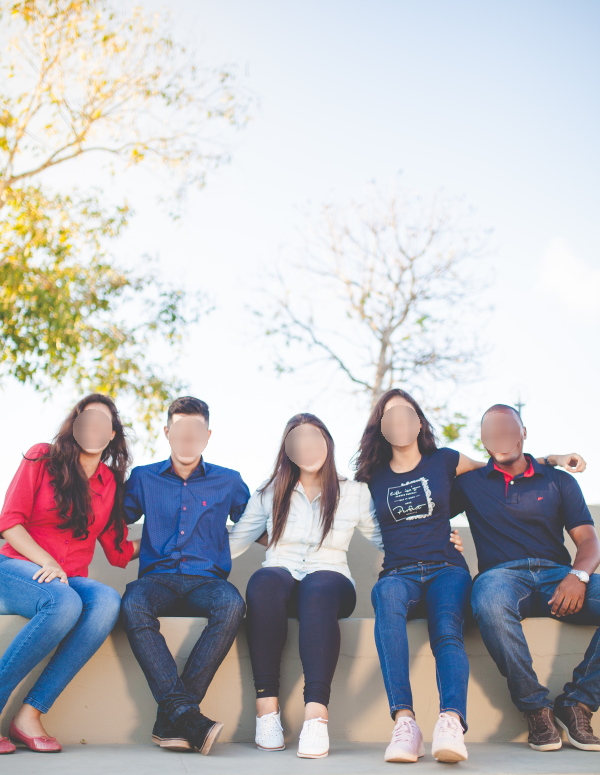



CNN: 4


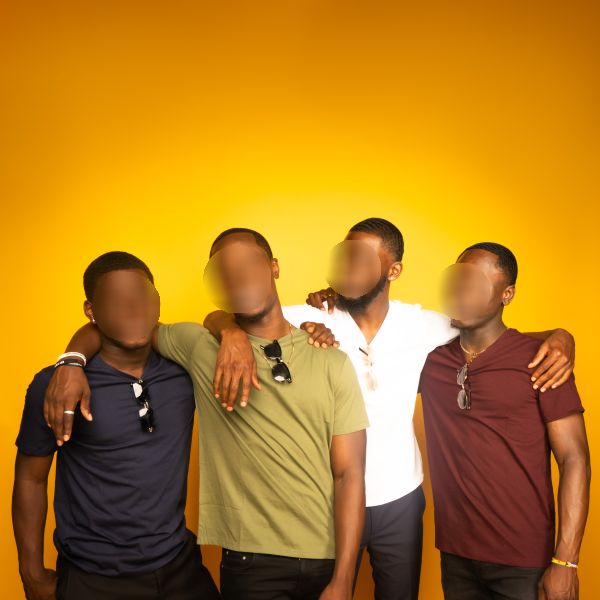



CNN: 2


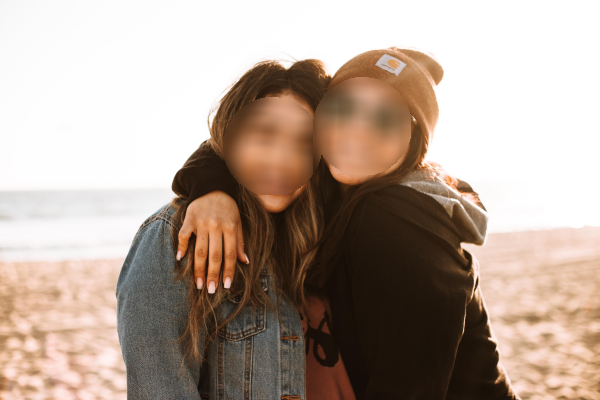



CNN: 3


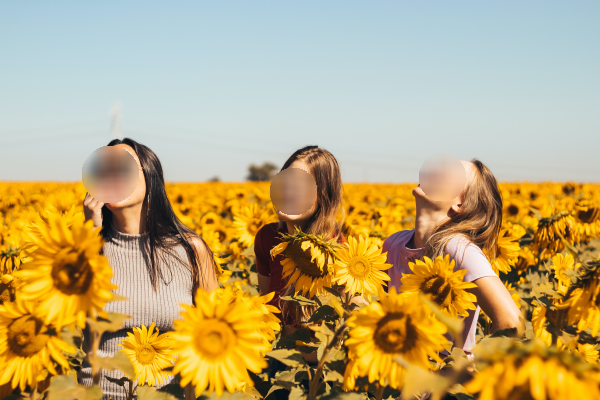



CNN: 2


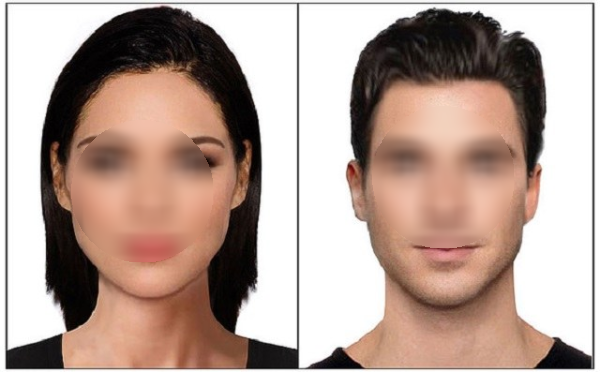



CNN: 2


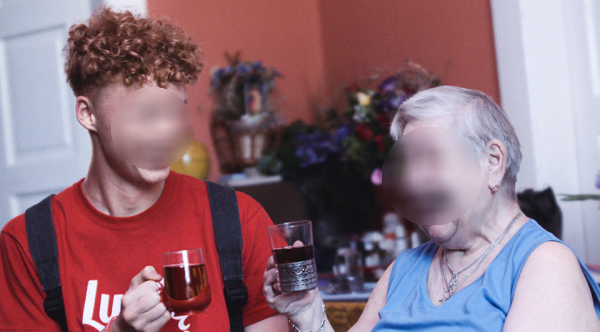



CNN: 1


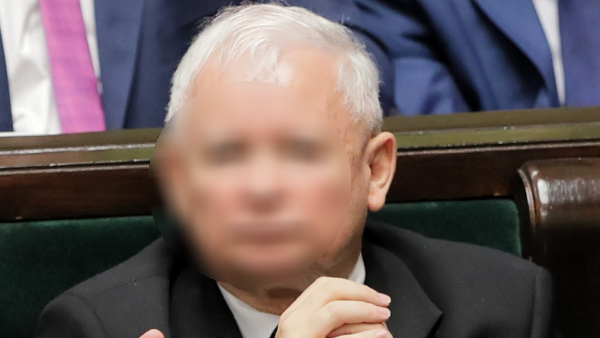

In [14]:
prec_list = []

AAA(img_list, prec_list)

### **Statistics**
Statystyki dotyczące przybliżonej skuteczności (w %) wykonanego działania na podstawie wyników pracy algorytmu oraz wcześniejszej deklaracji ilości twarzy do wykrycia

In [15]:
print(prec_list)

results = []
for i in range(0, len(prec_list)):
  result = int(prec_list[i]/fimage_list[i] * 100)
  results.append(result)

r = sum(results)/len(prec_list)

print("Final accuracy rate: " + "%.2f" % r + " % \n")

[5, 4, 2, 3, 2, 2, 1]
Final accuracy rate: 100.00 % 

